# **Financial Derivatives and High-Frequency Trading - Volatility modeling: Sergio Pulido**
Anas NAJOUI (anas.najoui@etud.univ-evry.fr) and Youssef Louraoui (20230348@etud.univ-evry.fr)

## **Preparation of the Working Environment on Python**

Below, we detail the essential Python packages that constitute the basis of our portfolio and run a script to check if the required packages for this project are well installed in the Python environment.

- Pandas for data manipulation.
- NumPy for mathematical operations and complex computations with data.
- SciPy in order to perform, for instance, the complex portfolio optimisation frameworks that we will implement in this project.
- Matplotlib, seaborn and ploty for data visualisation.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from scipy.integrate import quad
from scipy.stats import norm
from scipy.optimize import newton
from scipy.integrate import quad
from math import exp, sqrt, log, gamma

In [2]:
!pip install py_vollib
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv_bs

/Users/youssef/anaconda3/lib/python3.11/site-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


## **Exercise 1. Estimation of the parameter H**

### *1.1 Estimation of the parameter H: Simulate the path of the variance process $Vt$ (Part 1)*

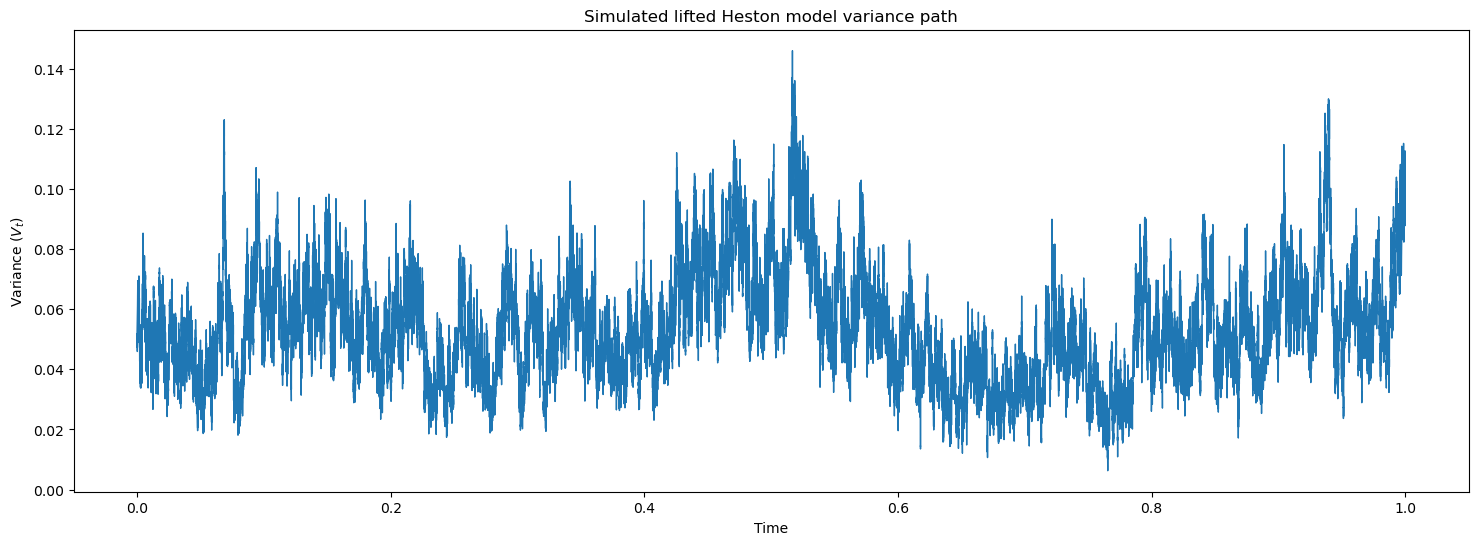

In [3]:
# Parameters for the simulation
initial_vol = 0.05  # Initial spot variance
mean_rev_speed = 0.3  # Speed of mean reversion, kappa in the correction
mean_vol = 0.05  # Long term mean variance
vol_of_vol = 0.1  # Volatility of volatility
alpha_param = 0.6  # Alpha parameter for the weights calculation, nu in the correction
hurst_param = 0.1  # Hurst parameter for the model
num_factors = 20  # Number of factors/terms in the approximation, num_terms in the correction
mean_rev_level = 2.5  # Mean reversion level, mean_reversion in the correction

# Calculate weights (c_i) and mean reversions (x_i) for the factors
weights = np.array([(mean_rev_level**(1-alpha_param)-1) *
                    (mean_rev_level**((1-alpha_param)*(i-1-num_factors/2))) /
                    (math.gamma(alpha_param) * math.gamma(2-alpha_param))
                    for i in range(1, num_factors+1)])

mean_reversions = np.array([(1-alpha_param) *
                            (mean_rev_level**(2-alpha_param)-1) *
                            (mean_rev_level**(i-1-num_factors/2)) /
                            ((2-alpha_param) * (mean_rev_level**(1-alpha_param)-1))
                            for i in range(1, num_factors+1)])

# Define time grid
start_time = 0
end_time = 1
num_steps = 10**5
time_step = (end_time - start_time) / num_steps
time_grid = [round(i*time_step, 7) for i in range(0, num_steps+1)]

# Generate Gaussian increments
gaussian_increments = np.random.normal(0, np.sqrt(time_step), num_steps)

# Initial forward variance curve function g0(t)
def initial_forward_variance(t, vol_0, kappa, theta, c, x):
    integral_part = (1 - np.exp(-x * t)) / x
    return vol_0 + kappa * theta * np.dot(c, integral_part)

# Initialize arrays to store values
variance_path = np.zeros(num_steps + 1)
factor_u = np.zeros(num_factors)
variance_path[0] = initial_forward_variance(0, initial_vol, mean_rev_speed, mean_vol, weights, mean_reversions)

# Simulate the variance path
for step in range(1, num_steps + 1):
    factor_u = 1/(1 + mean_reversions * time_step) * (factor_u - mean_rev_speed * variance_path[step-1] * time_step +
                                                       vol_of_vol * np.sqrt(max(0, variance_path[step-1])) *
                                                       gaussian_increments[step-1])
    variance_path[step] = initial_forward_variance(time_grid[step], initial_vol, mean_rev_speed, mean_vol, weights, mean_reversions) + np.dot(weights, factor_u)

# Plot the variance process
plt.figure(figsize=(18, 6))
plt.title("Simulated lifted Heston model variance path")
plt.xlabel("Time")
plt.ylabel("Variance ($V_t$)")
plt.plot(time_grid, variance_path, linewidth=1)
plt.show()

### *1.2 Estimation of the parameter H: Simulate the path of the variance process $Vt$ (Part 2)*

Estimated Hurst Parameter: 0.4674198890082209


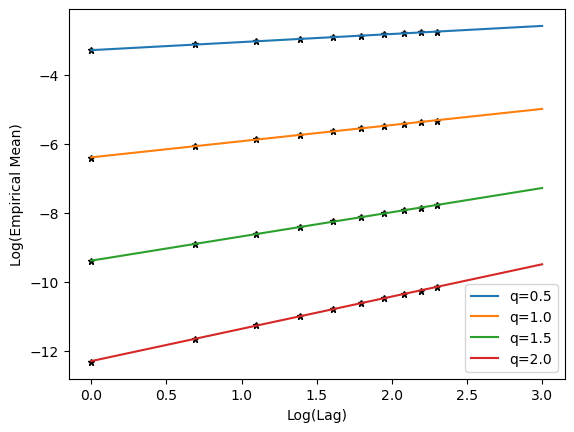

In [4]:
# Define the moments and lags
moments = np.array([0.5, 1, 1.5, 2])
time_lags = np.array([i for i in range(1, 11)])
empirical_means = np.zeros((len(time_lags), len(moments)))

# Function to calculate increments with lag
def calculate_increments(vol_path, lag, moment):
    path_length = len(vol_path) - lag
    increments = np.array([abs(vol_path[i + lag] - vol_path[i])**moment for i in range(path_length)])
    return increments

# Function to compute empirical mean
def compute_empirical_mean(vol_path, lag, moment):
    increments = calculate_increments(vol_path, lag, moment)
    empirical_value = increments.mean()
    return empirical_value

# Calculate empirical mean matrix for different lags and moments
for idx_lag, lag in enumerate(time_lags):
    for idx_mom, mom in enumerate(moments):
        empirical_means[idx_lag, idx_mom] = compute_empirical_mean(variance_path, lag, mom)

# Compute log of empirical means and log of lags
log_means = np.log(empirical_means)
log_time_lags = np.log(time_lags)

# Initialize arrays to store the slope and intercept for the line fit
slopes = np.zeros(len(moments))
intercepts = np.zeros(len(moments))

# Fit the log-log plot to a line to estimate the slopes
for idx_mom, mom in enumerate(moments):
    slopes[idx_mom], intercepts[idx_mom] = np.polyfit(log_time_lags, log_means[:, idx_mom], 1)

# Estimate the Hurst parameter H using the slope
estimated_hurst_param, _ = np.polyfit(moments, slopes, 1)

print("Estimated Hurst Parameter:", estimated_hurst_param)

# Plot the log-log graph with the fitted line
continuous_log_lags = np.linspace(0, 3, 1000)

# Plot the empirical means and fitted lines
for idx_mom, mom in enumerate(moments):
    plt.plot(log_time_lags, log_means[:, idx_mom], '*', markersize=5, color="black")
    fitted_line = intercepts[idx_mom] + slopes[idx_mom] * continuous_log_lags
    plt.plot(continuous_log_lags, fitted_line, label=f"q={mom}")

plt.xlabel("Log(Lag)")
plt.ylabel("Log(Empirical Mean)")
plt.legend()
plt.show()

### 1.3 Estimation of the parameter H: Simulate the path of the variance process $Vt$ (Part 3)*

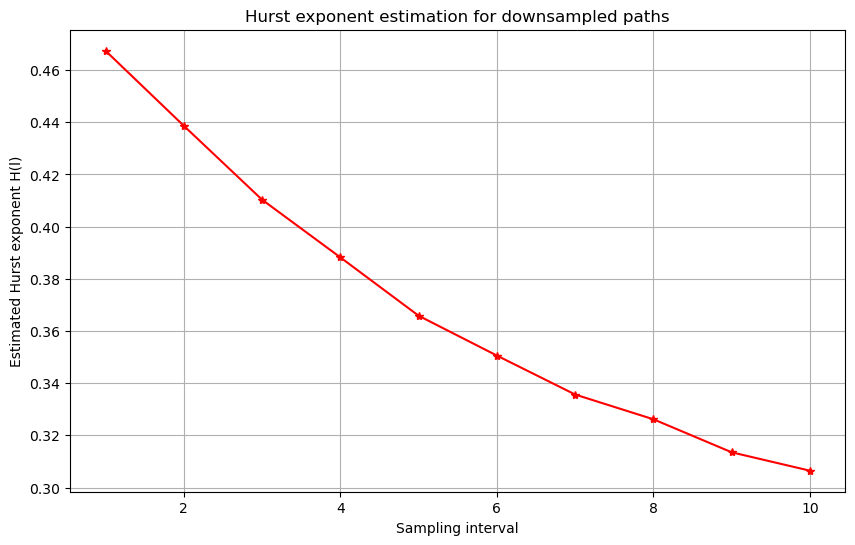

In [5]:
# Define moments and lags as per previous parts
moment_values = np.array([0.5, 1, 1.5, 2])
time_lags = np.array([i for i in range(1, 11)])

# Array of sampling intervals
sample_intervals = np.arange(1, 11).astype(int)
hurst_estimations = np.zeros(len(sample_intervals))
mean_matrix_downsampled = np.zeros((len(time_lags), len(moment_values)))

# Function to calculate empirical mean matrix for downsampled paths
def empirical_mean_downsample(time_lag, moment_q, downsampled_variance):
    return np.mean(calculate_increments(downsampled_variance, time_lag, moment_q))

# Estimating the Hurst exponent for different downsampled paths
for index, interval in enumerate(sample_intervals):
    # Downsampling the variance path
    downsampled_v = variance_path[::interval]

    # Calculate empirical means for the downsampled variance path
    for lag_index, lag in enumerate(time_lags):
        for moment_index, moment_q in enumerate(moment_values):
            mean_matrix_downsampled[lag_index, moment_index] = empirical_mean_downsample(lag, moment_q, downsampled_v)

    # Apply log transformation to means and lags
    logged_means = np.log(mean_matrix_downsampled)
    logged_lags = np.log(time_lags)

    # Initialize arrays for slopes and intercepts
    slopes = np.zeros(len(moment_values))

    # Fit linear model to log-log values to estimate slopes
    for moment_index, moment_q in enumerate(moment_values):
        slopes[moment_index], _ = np.polyfit(logged_lags, logged_means[:, moment_index], 1)

    # Fit linear model to estimate Hurst exponent
    hurst_estimations[index], _ = np.polyfit(moment_values, slopes, 1)

# Plot the estimated Hurst exponents for each downsampled path
plt.figure(figsize=(10, 6))
plt.plot(sample_intervals, hurst_estimations, marker='*', linestyle='-', color='red')
plt.title('Hurst exponent estimation for downsampled paths')
plt.xlabel('Sampling interval')
plt.ylabel('Estimated Hurst exponent H(l)')
plt.grid(True)
plt.show()


### *1.4 Estimation of the parameter H: Simulate the path of the variance process $Vt$ (Part 4)*

Simulate paths using a classical Brownian motion $ W$ instead of the variance process $ V$ (Part 4).

**Observations for Part 4 (Classical Brownian Motion):**
The estimated $ H$ values for the classical Brownian motion are very close to 0.5, which is expected since the classical Brownian motion has a Hurst parameter of 0.5. This indicates a memoryless process or a Markov process, where increments are independent and identically distributed.

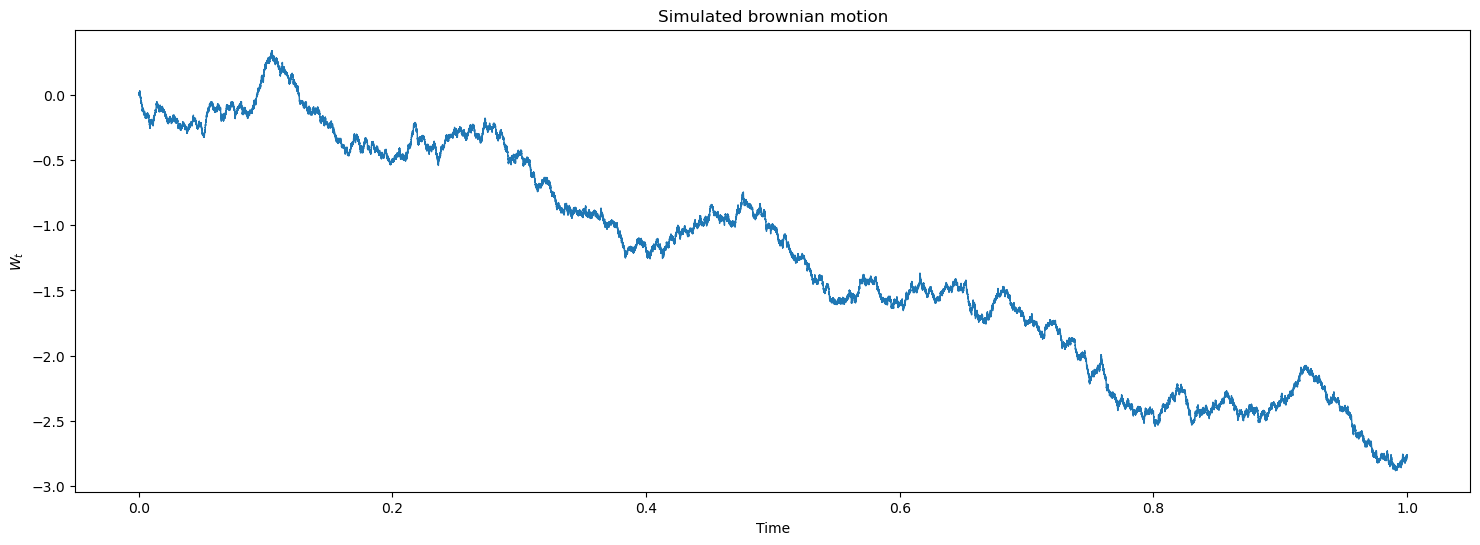

In [6]:
# Parameters for the Brownian motion simulation
total_time = 1
steps_bm = int(10**5)
delta_t = total_time / steps_bm
time_points_bm = np.linspace(0, total_time, steps_bm+1)

# Generate Gaussian increments and the Brownian motion
random_increments = np.random.normal(0, np.sqrt(delta_t), steps_bm)
brownian_motion = np.insert(np.cumsum(random_increments), 0, 0)

# Plot the Brownian motion
plt.figure(figsize=(18, 6))
plt.title("Simulated brownian motion")
plt.xlabel("Time")
plt.ylabel(r'$W_{t}$')
plt.plot(time_points_bm, brownian_motion, linewidth=1)
plt.show()

In [9]:
# Initializing variables and arrays
moment_orders = np.array([0.5, 1, 1.5, 2])
lags_set = np.array([i for i in range(1, 11)])
emp_means_matrix_bm = np.zeros((len(lags_set), len(moment_orders)))
hurst_estimate_vector_bm = np.zeros(len(lags_set))

# Calculating empirical mean matrix for the Brownian motion
for lag_index, lag in enumerate(lags_set):
    for moment_index, moment in enumerate(moment_orders):
        emp_means_matrix_bm[lag_index, moment_index] = empirical_average(lag, moment, brownian_motion)

# Logarithmic transformation for empirical means and lags
log_emp_means = np.log(emp_means_matrix_bm)
log_lags_bm = np.log(lags_set)

# Linear regression to estimate the slope for each moment order
slopes_bm = np.zeros(len(moment_orders))
intercepts_bm = np.zeros(len(moment_orders))

for i in range(len(moment_orders)):
    slopes_bm[i], intercepts_bm[i] = np.polyfit(log_lags_bm, log_emp_means[:, i], 1)

# Estimating the Hurst parameter H for the Brownian motion
estimated_hurst_bm, _ = np.polyfit(moment_orders, slopes_bm, 1)

# Print the estimated Hurst parameter for the Brownian motion
print("Estimated Hurst Parameter for Brownian Motion:", estimated_hurst_bm)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
# Plotting log(m(q, Δ)) against log(Δ)
plt.figure(figsize=(18, 6))
for i, moment in enumerate(moment_orders):
    plt.plot(log_lags_bm, log_emp_means[:, i], '*', markersize=5, color="black")
    plt.plot(np.linspace(min(log_lags_bm), max(log_lags_bm), 1000),
             intercepts_bm[i] + slopes_bm[i] * np.linspace(min(log_lags_bm), max(log_lags_bm), 1000),
             label=f"q={moment}")

plt.xlabel(r"Log($\Delta$)")
plt.ylabel(r"Log(m(q, $\Delta$))")
plt.legend()
plt.title("Log-Log plot of Empirical mean for brownian motion")
plt.show()


In [ ]:
# Calculating empirical means for downsampled Brownian motion and estimating Hurst parameter H
for k in range(len(lags_set)):
    downsampled_bm = brownian_motion[::lags_set[k]]

    for i in range(len(lags_set)):
        for j in range(len(moment_orders)):
            emp_means_matrix_bm[i, j] = empirical_average(lags_set[i], moment_orders[j], downsampled_bm)

    log_emp_means = np.log(emp_means_matrix_bm)
    slopes_bm = np.zeros(len(moment_orders))

    for i in range(len(moment_orders)):
        slopes_bm[i], _ = np.polyfit(log_lags_bm, log_emp_means[:, i], 1)

    hurst_estimate_vector_bm[k], _ = np.polyfit(moment_orders, slopes_bm, 1)

# Plotting estimated Hurst parameter H for different sampling intervals of Brownian motion
plt.figure(figsize=(18, 6))
plt.plot(lags_set, hurst_estimate_vector_bm, "-o", markersize=5, color="blue")
plt.title("Estimated Hurst parameter H for downsampled brownian motion")
plt.xlabel("Sampling interval (l)")
plt.ylabel("Estimated Hurst exponent H(l)")
plt.grid(True)
plt.show()

### *1.5 Estimation of the parameter H: Simulate the path of the variance process $Vt$ (Part 5)*

Simulate paths using a fractional Brownian motion $ W^H$ with $ H = 0.1$ using the Cholesky method (Part 5).

**Observations for Part 5 (Fractional Brownian Motion with $ H = 0.1$):**
The estimated $ H$ values for the fractional Brownian motion vary and are generally below the theoretical value of 0.1, which might be due to the small sample size (only $ 10^3$ steps) or the approximation errors in the simulation. Fractional Brownian motion with $ H < 0.5$ exhibits anti-persistent behavior, where increments are negatively correlated.

The variation in estimated $ H$ values for both the classical and fractional Brownian motions when using different sub-sampling factors $ l$ could reflect the changing properties of the sampled paths. For fractional Brownian motion, the estimation seems to be more sensitive to the choice of $ l$, which could be due to its long-range dependence and the impact of sampling on capturing this dependence.

These observations provide insight into the nature of the processes and the appropriateness of the estimation methods for different types of stochastic processes.

In [ ]:
# Simulation parameters for fractional Brownian motion (fBm)
num_points = int(10**3)
hurst_param = 0.1
total_time = 1  # Assuming T is total time and t0 is start time which is 0
time_increment = total_time / num_points
time_grid_fbm = np.array([round(i * time_increment, 7) for i in range(num_points + 1)])

# Function to calculate the covariance matrix for fBm
def fractional_brownian_covariance(time1, time2, hurst):
    return 0.5 * (abs(time2)**(2 * hurst) + abs(time1)**(2 * hurst) - abs(time2 - time1)**(2 * hurst))

# Construct the covariance matrix for fBm
cov_matrix = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(num_points):
        cov_matrix[i, j] = fractional_brownian_covariance(time_grid_fbm[i + 1], time_grid_fbm[j + 1], hurst_param)

# Perform Cholesky decomposition
cholesky_decomp = np.linalg.cholesky(cov_matrix)

# Generate Gaussian random variables and simulate fBm
normal_vars = np.random.normal(0, 1, num_points)
simulated_fbm = np.insert(np.dot(cholesky_decomp, normal_vars), 0, 0)

# Plot the simulated fractional Brownian motion
plt.figure(figsize=(18, 6))
plt.title("Simulated fractional brownian motion (fBM) - H = {}".format(hurst_param))
plt.xlabel("Time")
plt.ylabel(r'$W^H_t$')
plt.plot(time_grid_fbm, simulated_fbm, linewidth=1)
plt.show()

In [ ]:
# Defining moments and lags as per previous parts
q_values = np.array([0.5, 1, 1.5, 2])
time_delays = np.array([i for i in range(1, 11)])
mean_matrix_fbm = np.zeros((len(time_delays), len(q_values)))

# Function to calculate empirical means for fractional Brownian motion
def calc_means_for_fbm(time_delay, q_val, fbm_series):
    return np.mean(calculate_increments(fbm_series, time_delay, q_val))

# Calculate the empirical mean matrix for fractional Brownian motion
for i in range(len(time_delays)):
    for j in range(len(q_values)):
        mean_matrix_fbm[i, j] = calc_means_for_fbm(time_delays[i], q_values[j], simulated_fbm)

# Linear regression to estimate the slopes and Hurst exponent
log_means_fbm = np.log(mean_matrix_fbm)
log_delays_fbm = np.log(time_delays)
slopes_fbm = np.zeros(len(q_values))
intercepts_fbm = np.zeros(len(q_values))

for i in range(len(q_values)):
    slopes_fbm[i], intercepts_fbm[i] = np.polyfit(log_delays_fbm, log_means_fbm[:, i], 1)

estimated_H_fbm, _ = np.polyfit(q_values, slopes_fbm, 1)
print(f"Estimated Hurst Exponent for fBM: {estimated_H_fbm}")

# Plotting log(m(q, Δ)) against log(Δ) for fractional Brownian motion
plt.figure(figsize=(18, 6))
for i, q_val in enumerate(q_values):
    plt.scatter(log_delays_fbm, log_means_fbm[:, i], color="black", label=f"q={q_val}")
    plt.plot(np.linspace(min(log_delays_fbm), max(log_delays_fbm), 1000),
             intercepts_fbm[i] + slopes_fbm[i] * np.linspace(min(log_delays_fbm), max(log_delays_fbm), 1000),
             label=f"Linear fit q={q_val}")

plt.xlabel(r"Log($\Delta$)")
plt.ylabel(r"Log(m(q, $\Delta$))")
plt.legend()
plt.title("Log-Log plot of empirical mean for fBM")
plt.show()

In [ ]:
# Calculating the empirical mean matrix for downsampled fractional Brownian motion
mean_matrix_l_fbm = np.zeros((len(time_delays), len(q_values)))
hurst_vector_fbm = np.zeros(len(time_delays))

for k in range(len(time_delays)):
    downsampled_fbm = simulated_fbm[::time_delays[k]]
    for i in range(len(time_delays)):
        for j in range(len(q_values)):
            mean_matrix_l_fbm[i, j] = calc_means_for_fbm(time_delays[i], q_values[j], downsampled_fbm)

    log_means_l_fbm = np.log(mean_matrix_l_fbm)
    slopes_l_fbm = np.zeros(len(q_values))

    for i in range(len(q_values)):
        slopes_l_fbm[i], _ = np.polyfit(log_delays_fbm, log_means_l_fbm[:, i], 1)

    hurst_vector_fbm[k], _ = np.polyfit(q_values, slopes_l_fbm, 1)

# Plotting the estimated Hurst exponent for downsampled fractional Brownian motion
plt.figure(figsize=(18, 6))
plt.plot(time_delays, hurst_vector_fbm, "-o", color="blue", markersize=5)
plt.title("Estimated Hurst exponent for downsampled fBM")
plt.xlabel("Downsampling interval (l)")
plt.ylabel("Estimated Hurst exponent H(l)")
plt.grid(True)
plt.show()

## **Exercise 2: Implied volatility in the Lifted Heston model**

### *2.4 Implied volatility in the Lifted Heston model*

In [ ]:
class CH_Lifted_Heston:
    def __init__(self, steps, duration, factors, factor_scale, factor_roughness, base_vol, reversion_const, mean_target, vol_volatility, correlation):
        self.steps = steps
        self.duration = duration
        self.factors = factors
        self.factor_scale = factor_scale
        self.factor_roughness = factor_roughness
        self.base_vol = base_vol
        self.reversion_const = reversion_const
        self.mean_target = mean_target
        self.vol_volatility = vol_volatility
        self.correlation = correlation
        self.interval = duration / steps
        self.schedule = np.array([i * self.interval for i in range(steps + 1)])

        self.coefficients = np.array([(factor_scale ** (1 - factor_roughness) - 1) *
                                      (factor_scale ** ((1 - factor_roughness) * (i - 1 - factors / 2))) /
                                      (math.gamma(factor_roughness) * math.gamma(2 - factor_roughness))
                                      for i in range(1, factors + 1)])
        self.reversion_levels = np.array([(1 - factor_roughness) *
                                          (factor_scale ** (2 - factor_roughness) - 1) *
                                          (factor_scale ** (i - 1 - factors / 2)) /
                                          ((2 - factor_roughness) *
                                           (factor_scale ** (1 - factor_roughness) - 1))
                                          for i in range(1, factors + 1)])

    def initial_vol(self, time):
        integral_part = (1 - np.exp(-self.reversion_levels * time)) / self.reversion_levels
        return self.base_vol + self.reversion_const * self.mean_target * np.dot(self.coefficients, integral_part)

    def g0_curve(self):
        g0_vector = np.zeros(self.steps + 1)
        for k in range(1, self.steps + 1):
            g0_vector[k] = self.initial_vol(self.schedule[k])
        return g0_vector

    def riccati_solution(self, u, var):
        equation_result = 0.5 * ((1j*u)**2 - 1j*u) + (self.correlation * self.vol_volatility * 1j*u - self.reversion_const) * var + 0.5 * (self.vol_volatility**2) * var**2
        return equation_result

    def euler_scheme_psi(self, u):
        psi_vector = np.zeros(self.steps + 1, dtype=complex)
        psi = np.zeros(self.factors, dtype=complex)
        for k in range(1, self.steps + 1):
            F_val = self.riccati_solution(u, np.dot(psi, self.coefficients))
            psi_vector[k] = F_val
            psi = (1 / (1 + self.reversion_levels * self.interval)) * (psi + F_val * self.interval)
        return psi_vector

    def characteristic_func(self, u, S0):
        g0_vec = self.g0_curve()
        F_psi_vec = self.euler_scheme_psi(u)
        integral_sum = np.sum(F_psi_vec[:-1] * g0_vec[1:] * self.interval)
        return np.exp(1j*u * np.log(S0) + integral_sum)

    def option_price(self, S0, K, L, alpha_2):
        def integrand_function(u):
            char_func_val = self.characteristic_func(u - (alpha_2 + 1) * 1j, S0) * np.exp(-1j * u * np.log(K))
            denominator = (alpha_2 + 1j * u) * (alpha_2 + 1 + 1j * u)
            return np.real(char_func_val / denominator)

        integral_result, _ = quad(integrand_function, 0, L, limit=1000)
        return (np.exp(-alpha_2 * np.log(K)) / np.pi) * integral_result

    def plot_iv(self, S0, L, alpha_2, log_strikes, graph_title, risk_free_rate=0):
        strikes = np.exp(log_strikes)
        ivs = []
        for strike_price in strikes:
            option_val = self.option_price(S0, strike_price, L, alpha_2)
            implied_vol = iv_bs(option_val, S0, strike_price, self.duration, risk_free_rate, 'c')
            ivs.append(implied_vol)

        plt.plot(log_strikes, ivs, marker='*', linestyle='-', label=f'Factors={self.factors}')
        plt.xlabel('Log-strike price')
        plt.ylabel('IV')
        plt.title(graph_title)
        plt.legend()

### *2.5 Implied volatility in the Lifted Heston model (Part 5)*

In [ ]:
# Given parameters for drawing the graph in the exercise
S0 = 1
K = 0.5
rho = -0.7
L = 100
lam, theta, nu = 0.3, 0.02, 0.3
v0 = 0.02
alpha = 0.6
alpha_2 = 1
M = 100
T = 1
l_K = np.linspace(-1.2, 0.2, 20)
title = 'IV vs Log-strike for 1-year'

In [ ]:
# Plotting for different values of n
n_values = [5, 10, 20, 50]
for n in n_values:
    rn_scaled = 1 + 10 * pow(n, -0.9)
    # Utilizing the modified class for simulation
    model = CH_Lifted_Heston(steps=M, duration=T, factors=n, factor_scale=rn_scaled, factor_roughness=alpha, base_vol=v0, reversion_const=lam, mean_target=theta, vol_volatility=nu, correlation=rho)

    # Preparing for plotting
    log_strikes = l_K
    implied_vols = []
    for log_K in log_strikes:
        strike_price = np.exp(log_K)
        call_price = model.option_price(S0, strike_price, L, alpha_2)
        implied_vol = iv_bs(call_price, S0, strike_price, T, 0, 'c')
        implied_vols.append(implied_vol)

    plt.plot(log_strikes, implied_vols, label=f'n={n}')

plt.xlabel('Log-strike')
plt.ylabel('IV')
plt.title(title)
plt.legend()
plt.figure(figsize=(12, 8))
plt.show()

In [ ]:
# Updated parameters for the shorter duration
T = 1 / 26
L = 1000
l_K = np.linspace(-0.15, 0.05, 20)
title = 'IV vs Log-strike for 2 weeks'

# Given parameters for the model
S0 = 1
rho = -0.7
lam, theta, nu = 0.3, 0.02, 0.3
v0 = 0.02
alpha = 0.6
alpha_2 = 1
M = 100

# Plotting implied volatility for different n values with a duration of 2 weeks
n_values = [5, 10, 20, 50]
for n in n_values:
    rn_scaled = 1 + 10 * pow(n, -0.9)
    # Instantiate the model with the correct parameters
    model = CH_Lifted_Heston(steps=M, duration=T, factors=n, factor_scale=rn_scaled, factor_roughness=alpha, base_vol=v0, reversion_const=lam, mean_target=theta, vol_volatility=nu, correlation=rho)

    # Prepare for plotting
    log_strikes = l_K
    implied_vols = []
    for log_K in log_strikes:
        strike_price = np.exp(log_K)
        call_price = model.option_price(S0, strike_price, L, alpha_2)
        implied_vol = iv_bs(call_price, S0, strike_price, T, 0, 'c')
        implied_vols.append(implied_vol)

    plt.plot(log_strikes, implied_vols, label=f'n={n}')

plt.xlabel('Log-strike')
plt.ylabel('IV')
plt.title(title)
plt.legend()
plt.figure(figsize=(12, 8))
plt.show()

## **Exercise 3: Implied volatility in the Lifted/Rough Bergomi model**

### *3.3 Implied volatility in the Lifted/Rough Bergomi model (Part 3)*

In [ ]:
# Global parameters
n=20
V0=0.05
lam=0.3
theta=0.05
mu=0.1
alpha=0.6
r=2.5
m=10**5

In [ ]:
def list_of_C(alpha, r, n):
    l = []
    c1 = gamma(alpha) * gamma(2 - alpha)
    c = r ** (1 - alpha)
    for i in range(1, n + 1):
        l.append(((c - 1) / c1) * c ** (i - 1 - n / 2))
    return l

def list_of_X(alpha, r, n):
    l = []
    c1 = (1 - alpha) * (r ** (2 - alpha) - 1)
    c2 = (2 - alpha) * (r ** (1 - alpha) - 1)
    for i in range(1, n + 1):
        l.append((c1 / c2) * (r ** (i - 1 - n / 2)))
    return l

def K_n(s, n, r):
    c = np.array(list_of_C(alpha, r, n))
    x = np.array(list_of_X(alpha, r, n))
    return np.dot(c, np.exp(-x * s))

def integral_Kn(t, n, r):
    trunc = 20
    step = t / trunc
    sum_integral = 0
    for i in range(trunc + 1):
        sum_integral += (K_n(i * step, n, r) ** 2) * step
    return sum_integral

def BS_price(k,S,T,sigma):
  d1=(np.log(S/k)+(sigma**2/2)*T)/(sigma*np.sqrt(T))
  d2=(np.log(S/k)-(sigma**2/2)*T)/(sigma*np.sqrt(T))
  return S*(norm.cdf(d1)-(k/S)*(norm.cdf(d2)))

def imp_vol(S, K , T ,market_price):

      price_difference = 0.00001
      volatility = 0.2
      step = 0.0001

      for i in range(100000):
          call_price = BS_price(K,S, T, sigma = volatility)
          difference = market_price - call_price
          if difference > price_difference:
              volatility = volatility + step
          elif difference < 0 and abs(difference) > price_difference:
              volatility = volatility - step
          elif abs(difference) < price_difference:
              return volatility
      return volatility #if best value not found


In [ ]:
def Sim_Lifted_Bergomi(T, M, H, ksi, S0, V0, nu, rho, n):
    dt = T / M
    c1 = nu * sqrt(2 * H) * gamma(H + 0.5)
    c2 = H * (nu ** 2) * (gamma(H + 0.5) ** 2)

    r = 1 + 10 * (n) ** (-0.9)
    V = [V0]
    S = [S0]

    Y_previous = np.zeros(n)
    c = np.array(list_of_C(alpha, r, n))
    x = np.array(list_of_X(alpha, r, n))
    cov_matrix = dt * np.array([[1, rho], [rho, 1]])
    chol_matrix = np.linalg.cholesky(cov_matrix)

    for i in range(1, M + 1):
        Z = np.dot(chol_matrix, np.random.randn(2))
        W, BM = Z[0], Z[1]

        Y = Y_previous - (Y_previous * x * dt) + W
        Y_previous = Y

        integral = np.dot(c, Y)
        V.append(ksi * np.exp(c1 * integral - c2 * integral_Kn(i * dt, n, r)))
        S.append(S[i-1] + S[i-1] * np.sqrt(V[i-1]) * BM)

    return [S, V]

In [ ]:
# Plotting implied volatility smiles
T, H, nu, rho, ksi, M, S0 = 1, 0.1, 1.9, -0.9, 0.02, 100, 1
K_range = np.linspace(np.exp(-0.3), np.exp(0.3), 10)
log_moneyness = [np.log(k / S0) for k in K_range]

for n in [5, 10, 20]:
    implied_vols = []
    for k in K_range:
        S, V = Sim_Lifted_Bergomi(T, M, H, ksi, S0, V0, nu, rho, n)
        price = max(S[-1] - k, 0)  # Directly calculate the payoff for simplicity
        # Correctly calculate implied volatility from the price
        implied_vol = imp_vol(S0, k, T, price)
        implied_vols.append(implied_vol)

    plt.plot(log_moneyness, implied_vols, label=f'n={n}')

plt.xlabel("Log-Moneyness")
plt.ylabel("IV")
plt.title("IV smiles for maturity 1 Year")
plt.legend()
plt.show()

In [ ]:
def Price_Bergomi(T,M,H,ksi,S0,V0,rho,nu,K,n): # This function is to compute the price by the MC method so we had to simulate a lot of vactor S path
                                               # Given by the previous function the we take the value of S at the maturity and compute max(S_T-K,0)

  N=10000
  sum=0


  for i in range(N):
    pay=(simulation(T,M,H,ksi,S0,V0,nu,rho,n)[0][-1]-K)
    payoff=(pay*(pay>0))
    sum+=payoff

  return (1/N)*sum

In [ ]:
Price_Bergomi(1,100,0.1,0.02,1,V0,-0.9,1.9,1.1,20)

In [ ]:
K=np.linspace(np.exp(-0.3),np.exp(0.3),10)
log_mon=[np.log(k/1) for k in K]
for n in [5,10,20]:
    #print("n ",n)

    vol=[]

    for k in K:
        #print(k)
        C=Price_Bergomi(T,M,H,ksi,S0,V0,rho,nu,k,n)
        vol.append(imp_vol(1,k,1,C))
    plt.plot(log_mon, vol, label=n)

plt.xlabel("Log−moneyness")
plt.ylabel("implied volatility")
plt.title(" the implied volatility smiles for Maturity 1 year")
plt.legend()
plt.show()

In [ ]:
T=1
H=0.1
nu=1.9
rho=-0.9
ksi=0.02
M=100
S0=1

## **Exercise 4: Options on VIX**

### *4.1 Options on VIX (Part 1)*

In [ ]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
from scipy.optimize import newton

In [ ]:
# Define the parameters for the Heston model
kappa = 3.0  # rate of reversion
theta = 0.2  # long-term variance
sigma = 0.1  # volatility of volatility
rho = -0.5   # correlation coefficient
v0 = 0.1     # initial variance
T = 1        # time to maturity
r = 0.05     # risk-free rate
S0 = 100     # spot price
K = 100      # strike price

In [ ]:
# Characteristic function of the Heston model
def heston_char_func(u, T, r, kappa, theta, sigma, v0, rho):
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt(xi**2 + (sigma**2) * (u*1j + u**2))
    g = (xi - d) / (xi + d)
    C = r*u*1j*T + (kappa*theta/(sigma**2)) * ((xi - d)*T - 2*np.log((1 - g*np.exp(-d*T))/(1 - g)))
    D = (xi - d) / (sigma**2) * ((1 - np.exp(-d*T)) / (1 - g*np.exp(-d*T)))
    return np.exp(C + D*v0 + u*1j*np.log(S0))

# Integration of the characteristic function
def heston_integrand(u, S0, K, T, r, kappa, theta, sigma, v0, rho):
    cf_val = heston_char_func(u - 0.5*1j, T, r, kappa, theta, sigma, v0, rho)
    return (np.exp(-1j*u*np.log(K)) * cf_val / (u*1j)).real

# Function to calculate the call price in Heston model
def heston_call_price(S0, K, T, r, kappa, theta, sigma, v0, rho):
    integrand = lambda u: heston_integrand(u, S0, K, T, r, kappa, theta, sigma, v0, rho)
    integral = quad(integrand, 0, np.inf)[0]
    return S0 - np.sqrt(S0*K)*np.exp(-r*T)*integral/np.pi


In [ ]:
# Newton-Raphson method to find the implied volatility
def newton_raphson_iv(call_price, S0, K, T, r):
    # Initial guess for implied volatility
    iv = np.sqrt(2 * abs((np.log(S0 / K) + r * T) / T))

    # Newton-Raphson iteration
    for i in range(10):
        price = heston_call_price(S0, K, T, r, kappa, theta, sigma, v0, rho)
        vega = (heston_call_price(S0, K, T, r, kappa, theta, sigma, v0 + 0.0001, rho) - price) / 0.0001
        iv -= (price - call_price) / vega

        # Break if the change is too small
        if abs((price - call_price) / vega) < 1e-5:
            break

    return iv

In [ ]:
# Test the function with market call price
market_call_price = heston_call_price(S0, K, T, r, kappa, theta, sigma, v0, rho)
implied_vol = newton_raphson_iv(market_call_price, S0, K, T, r)

print(f"The implied volatility is: {implied_vol:.2f}%")

In [ ]:
# Define the parameters for the Heston model
params = {
    'kappa': 3.0,  # rate of reversion
    'theta': 0.2,  # long-term variance
    'sigma': 0.1,  # volatility of volatility
    'rho': -0.5,   # correlation coefficient
    'v0': 0.1,     # initial variance
    'r': 0.05,     # risk-free rate
    'S0': 100,     # spot price
}

In [ ]:
# Characteristic function of the Heston model
def heston_char_func(u, T, params):
    kappa, theta, sigma, rho, v0, r, S0 = [params[k] for k in ('kappa', 'theta', 'sigma', 'rho', 'v0', 'r', 'S0')]
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt(xi**2 + (sigma**2) * (u*1j + u**2))
    g = (xi - d) / (xi + d)
    C = r*u*1j*T + (kappa*theta/(sigma**2)) * ((xi - d)*T - 2*np.log((1 - g*np.exp(-d*T))/(1 - g)))
    D = (xi - d) / (sigma**2) * ((1 - np.exp(-d*T)) / (1 - g*np.exp(-d*T)))
    return np.exp(C + D*v0 + u*1j*np.log(S0))

# Integration of the characteristic function
def heston_integrand(u, K, T, params):
    cf_val = heston_char_func(u - 0.5*1j, T, params)  # Use 'params' to get the parameters
    return (np.exp(-1j*u*np.log(K)) * cf_val / (u*1j)).real

# Calculate the call price in the Heston model
def heston_call_price(K, T, params):
    integrand = lambda u: heston_integrand(u, K, T, params)  # Pass 'params' as a single argument
    integral = quad(integrand, 0, np.inf)[0]
    return params['S0'] - np.sqrt(params['S0']*K)*np.exp(-params['r']*T)*integral/np.pi

In [ ]:
# Find the implied volatility using the Newton-Raphson method
# Corrected Newton-Raphson iteration within the find_implied_vol function
def find_implied_vol(call_price, K, T, params):
    # Initial guess for implied volatility
    S0 = params['S0']
    r = params['r']
    iv = np.sqrt(2 * abs((np.log(S0 / K) + r * T) / T))

    for i in range(10):
        # Use the 'params' dictionary instead of individual parameters
        price = heston_call_price(K, T, params)
        # Adjust 'v0' within 'params' for vega calculation
        params_vega = params.copy()
        params_vega['v0'] += 0.0001
        vega = (heston_call_price(K, T, params_vega) - price) / 0.0001
        iv -= (price - call_price) / vega

        # Break if the change is too small
        if abs((price - call_price) / vega) < 1e-5:
            break

    return iv

In [ ]:
# Plot the volatility smile
# Plot the VIX options volatility smile
strikes = np.linspace(80, 120, num=10)  # Define a range of strike prices
T = 1  # Maturity
vol_smiles = []

for K in strikes:
    # Correctly pass the parameters dictionary
    call_price = heston_call_price(K, T, params)
    implied_vol = find_implied_vol(call_price, K, T, params)
    vol_smiles.append(implied_vol)

plt.figure(figsize=(10, 6))
plt.plot(strikes, vol_smiles, marker='o', linestyle='-', color='blue')
plt.title('VIX options volatility smile - classical Heston model')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (%)')
plt.grid(True)
plt.show()

In [ ]:
# Heston model parameters
params = {
    "kappa": 3.0,  # Speed of mean reversion
    "theta": 0.05,  # Long-term volatility (variance)
    "sigma": 0.1,  # Volatility of volatility
    "rho": -0.7,  # Correlation between asset price and volatility
    "v0": 0.05,  # Initial variance
    "r": 0.03,  # Risk-free rate
    "S0": 1,  # Initial asset price
    "T": 1,  # Time to maturity
    "K": np.linspace(0.8, 1.2, 40),  # Strike prices
    "M": 100,  # Number of time steps
    "I": 10000  # Number of simulation paths
}

np.random.seed(42)  # For reproducibility

def simulate_heston(params):
    kappa, theta, sigma, rho, v0 = params['kappa'], params['theta'], params['sigma'], params['rho'], params['v0']
    T, M, I = params['T'], params['M'], params['I']
    dt = T / M
    S0 = params['S0']

    # Initialize paths
    S = np.zeros((M + 1, I))
    v = np.zeros((M + 1, I))
    S[0] = S0
    v[0] = v0

    # Generate correlated Brownian motions
    dwz = np.random.normal(size=(M + 1, I, 2))
    dwz[:, :, 1] = rho * dwz[:, :, 0] + np.sqrt(1 - rho ** 2) * dwz[:, :, 1]

    for t in range(1, M + 1):
        v[t] = np.maximum(v[t-1] + kappa * (theta - np.maximum(v[t-1], 0)) * dt + sigma * np.sqrt(np.maximum(v[t-1], 0) * dt) * dwz[t-1, :, 1], 0)
        S[t] = S[t-1] * np.exp((params['r'] - 0.5 * np.maximum(v[t-1], 0)) * dt + np.sqrt(np.maximum(v[t-1], 0) * dt) * dwz[t-1, :, 0])

    return S, v

def price_option(S, K, r, T):
    payoff = np.maximum(S[-1] - K, 0)
    price = np.exp(-r * T) * np.mean(payoff)
    return price

# Simulate Heston model
S, v = simulate_heston(params)

# Price options for different strike prices
option_prices = [price_option(S, K, params['r'], params['T']) for K in params['K']]

plt.figure(figsize=(10, 6))
plt.plot(params['K'], option_prices, label='Option Price')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Option Prices under Heston Model')
plt.legend()
plt.grid(True)
plt.show()